## Importamos las bibliotecas

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chisquare
from math import pi, cos
from keras.models import Sequential
from keras.layers import Dense, Input
from math import exp, pi, cos  # Make sure exp is imported here
import tensorflow as tf
import time
import datetime #

## Definimos las variables

In [64]:

phase = np.random.rand() * 2 * pi
PtBatMax, PtMaxPanel = 43.68, 24.24
K, Eff = 191.1, 21.528 / 100
TInitial, TFinal, Dt = 0.0, 97.0, 1.0
SocInitial, HardDeck, SoftDeck = 95, 20, 30
NomConsum = 2
VOLTAGE = 12.0
DURATION_OF_ORBIT = 94.6  # Duración de una órbita en minutos


## Dataframe
- TaskID
- Potencia
- StartTime

In [65]:
'''
TasksDf = pd.DataFrame({
    'TaskID': [1, 2, 3, 4],
    'Power': [1.5, 2.0, 1.0, 2.5],
    'StartTime': [10, 30, 50, 70],
    'Duration': [5, 1, 5, 1],
    'PriorityTransmission': [0.2, 1, 0.4, 0.3],
    'PriorityExecution': [0.2, 1, 0.1, 0.9]
})


def load_tasks_from_csv(filepath):
    try:
        # Asume que el delimitador es una coma, y especifica los nombres de las columnas si es necesario
        TasksDf = pd.read_csv(filepath, delimiter=',', names=['TaskID', 'Power', 'StartTime', 'Duration', 'PriorityTransmission', 'PriorityExecution'], header=None)
        print("Tareas cargadas correctamente.")
        print(TasksDf)
        return TasksDf
    except Exception as e:
        print(f"Error al cargar las tareas: {e}")
        return pd.DataFrame()  # Retorna un DataFrame vacío en caso de error '''


'''
def load_tasks_from_csv(filepath):
    try:
        # Asume que el delimitador es una coma, y especifica los nombres de las columnas si es necesario
        TasksDf = pd.read_csv(filepath, delimiter=',', names=['TaskID', 'Power', 'StartTime', 'Duration', 'PriorityTransmission', 'PriorityExecution'], header=None)
        print("Tareas cargadas correctamente.")
        print(TasksDf)  # Imprime el contenido del DataFrame
        return TasksDf
    except Exception as e:
        print(f"Error al cargar las tareas: {e}")
        return pd.DataFrame()  # Retorna un DataFrame vacío en caso de error

# Llama a la función con la ruta del archivo CSV
ruta_del_archivo = "/content/tareas.csv"  # Reemplaza "ruta/del/archivo.csv" con la ruta real de tu archivo
load_tasks_from_csv(ruta_del_archivo)
'''

def load_tasks_from_csv(filepath):
    try:
        # Lee el archivo CSV y carga sus datos en un DataFrame
        tasks_df = pd.read_csv(filepath)

        # Muestra el contenido del DataFrame
        print("Contenido del DataFrame:")
        print(tasks_df)

        return tasks_df
    except Exception as e:
        print(f"Error al cargar las tareas desde el archivo CSV: {e}")
        return pd.DataFrame()  # Retorna un DataFrame vacío en caso de error

# Ruta del archivo CSV
archivo_csv = "/content/tareas.csv"  # Reemplaza "ruta/del/archivo.csv" con la ruta real de tu archivo

# Llama a la función para cargar el archivo CSV en un DataFrame
TasksDf = load_tasks_from_csv(archivo_csv)






Contenido del DataFrame:
   TaskID  Power  StartTime  Duration  PriorityTransmission  PriorityExecution
0       1    1.5         10         5                   0.2                0.2
1       2    2.0         30         1                   1.0                1.0
2       3    1.0         50         5                   0.4                0.1
3       4    2.5         70         1                   0.3                0.9


## dispersion σ

In [66]:

# Define the dispersion (σ) as a constant for now
sigma = 1  # Adjust this as necessary


## g(k) define los días que tarda en transmitir los datos de las tareas ejecutadas

In [67]:
# Define the g(k) function
def g(k):
    if k == 1:
        return 1
    elif k == 2:
        return 0.5
    elif k == 3:
        return 0.25
    else:
        return 0

## Definimos la función de recompensa

In [68]:
def task_reward(task, t_required, t_actual, sigma, d, k):
    s_j = 1 if task['TaskID'] in historical_task_status else 0
    p_j = task['PriorityExecution']
    t_f = t_actual - t_required
    gaussian_penalty = exp(-(t_f ** 2) / (2 * sigma ** 2))
    return s_j * p_j * gaussian_penalty * d * g(k)

## Definimos la función de recompensa total

In [69]:
# Define the overall reward function
def total_reward(tasks_df, historical_task_status, socs, E_max, E_L, alpha, sigma, k):
    Y_j_total = sum(task_reward(task, task['StartTime'], task['Duration'], sigma, 1, k) for _, task in tasks_df.iterrows())
    soc_penalty = alpha * sum(((E_i - E_L) / (E_max - E_L)) for E_i in socs)
    return Y_j_total - soc_penalty

## Define la potencia disponible

In [70]:
def available_power(t, phase, k, efficiency, pt_max_panel):
    return max(pt_max_panel * cos(2 * pi * t / TFinal + phase) * efficiency * k, 0)


### Define la Ejecucuión de tareas

In [71]:

def execute_tasks(times, tasks_df):
    # Inicializa arrays para registrar el consumo energético, si una tarea está activa y los datos generados
    consumption = np.zeros(len(times))
    task_active = np.zeros(len(times), dtype=bool)
    data_generated = np.zeros(len(tasks_df))  # Vector para almacenar los tamaños de datos generados
    historical_task_status = np.zeros((len(times), len(tasks_df)), dtype=int)  # Rastrea el estado activo histórico de todas las tareas

    # Itera sobre cada tarea en el DataFrame
    for index, task in tasks_df.iterrows():
        # Encuentra el índice de inicio y fin basado en los tiempos de inicio y duración de la tarea
        start_index = np.argmax(times >= task['StartTime'])
        end_index = np.argmax(times >= task['StartTime'] + task['Duration'])

        # Si se encuentran índices de inicio y fin válidos
        if start_index and end_index:
            # Distribuye el consumo de energía uniformemente a lo largo del intervalo de la tarea
            consumption[start_index:end_index + 1] += task['Power'] / (end_index - start_index + 1)
            # Marca como activa la tarea en los tiempos correspondientes
            task_active[start_index:end_index + 1] = True
            # Genera un tamaño aleatorio de datos entre 100 y 500 KB
            data_generated[index] = np.random.randint(100, 501)
            # Marca como activa la tarea en el estado histórico durante la duración de la tarea
            historical_task_status[start_index:end_index + 1, index] = 1

    # Preserva el estado histórico de tareas que se han ejecutado
    for t in range(1, len(times)):
        historical_task_status[t] |= historical_task_status[t-1]

    # Devuelve los resultados del consumo, estado histórico de las tareas, tareas activas y datos generados
    return consumption, historical_task_status, task_active, data_generated

# Ejemplo de uso:
# Supón que tienes un DataFrame llamado tasks_df y un array de tiempos times, puedes llamar a la función así:
# consumption, historical_task_status, task_active, data_generated = execute_tasks(times, tasks_df)


## Muestra texto de una tarea ejecutandose o no

In [72]:
def is_task_running(times, task_active):
    for t, active in zip(times, task_active):
        if active:
            print(f"At minute {t}, a task is running.")
        else:
            print(f"At minute {t}, no task is running.")


### Administración del SoC

In [73]:
def manage_soc(times, power, consumption, soc_initial, pt_bat_max, dt, nom_consum):
    soc = np.zeros(len(times))
    soc[0] = soc_initial
    for i in range(1, len(times)):
        energy_generated = power[i - 1] * dt / 60
        energy_consumed = (nom_consum + consumption[i - 1]) * dt / 60
        soc[i] = soc[i - 1] + (energy_generated - energy_consumed) * 100 / pt_bat_max
        soc[i] = max(0, min(100, soc[i]))
    return soc

### Calcula las Derividas

In [74]:
def calculate_derivatives(data, dt):
    d1 = np.zeros(len(data))
    d2 = np.zeros(len(data))
    for i in range(2, len(data)):
        d1[i] = (3 * data[i] - 4 * data[i - 1] + data[i - 2]) / (2 * dt)
        if i > 2:
            d2[i] = (2 * data[i] - 5 * data[i - 1] + 4 * data[i - 2] - data[i - 3]) / dt**2
    return d1, d2

### Muestreo de parametros


In [75]:

def sample_parameters(n):
    """
    Esta función simula el muestreo de parámetros de dos distribuciones normales.

    Args:
    n (int): Número de muestras a generar.

    Returns:
    list: Una lista de tuplas, cada tupla contiene dos valores flotantes correspondientes
          a los parámetros muestreados de las dos distribuciones normales.
    """

    # Lista vacía para almacenar los parámetros muestreados
    sampled_params = []

    # Bucle para generar 'n' muestras
    for _ in range(n):
        # Muestrea 'k' de una distribución normal con media 191.1 y desviación estándar 5
        k_sampled = norm.rvs(191.1, 5)
        # Muestrea 'eff' de una distribución normal con media 0.21528 y desviación estándar 0.01
        eff_sampled = norm.rvs(0.21528, 0.01)

        # Añade los parámetros muestreados a la lista como una tupla
        sampled_params.append((k_sampled, eff_sampled))

    # Devuelve la lista de parámetros muestreados
    return sampled_params

# Ejemplo de uso de la función:
# sample_params = sample_parameters(10)
# Esto generará una lista de 10 tuplas, cada una con valores de 'k' y 'eff' muestreados.


### Aniliza los rangos de tiempo en el Soc


In [76]:
def analyze_time_in_soc_ranges(socs, dt):
    """
    Analiza el tiempo que cada valor de estado de carga (SoC) pasa en rangos específicos.

    Args:
    socs (list or array): Lista o array de valores del estado de carga.
    dt (int or float): Incremento de tiempo que representa cada muestra en 'socs'.

    Returns:
    dict: Diccionario con los rangos de porcentaje como claves y el tiempo total acumulado en cada rango como valores.
    """
    # Define los rangos de porcentaje de 0 a 100% en incrementos de 10%
    ranges = np.arange(0, 110, 10)
    time_in_ranges = {}

    # Inicializa un diccionario para almacenar el tiempo acumulado en cada rango
    for i in range(len(ranges) - 1):
        range_key = f"{ranges[i]}%-{ranges[i+1]}%"
        time_in_ranges[range_key] = 0

    # Itera sobre cada valor de SoC
    for soc in socs:
        # Determina en qué rango cae cada SoC
        for i in range(len(ranges) - 1):
            if ranges[i] <= soc < ranges[i+1]:
                range_key = f"{ranges[i]}%-{ranges[i+1]}%"
                time_in_ranges[range_key] += dt
                break  # Sale del bucle una vez encontrado el rango

        # Trata el caso especial donde el SoC es exactamente 100%
        if soc == 100:
            range_key = f"{ranges[-2]}%-{ranges[-1]}%"
            time_in_ranges[range_key] += dt

    # Devuelve el diccionario con el tiempo acumulado en cada rango
    return time_in_ranges

# Ejemplo de uso:
# soc_values = [20, 35, 50, 65, 80, 95, 100]
# dt_value = 1  # cada muestra representa 1 minuto
# result = analyze_time_in_soc_ranges(soc_values, dt_value)


### Evaluación del desempeño

In [77]:
def evaluate_performance(time_in_ranges):
    """
    Evalúa el desempeño basado en el tiempo pasado en determinados rangos de porcentaje.

    Args:
    time_in_ranges (dict): Diccionario con los rangos de porcentaje como claves y el tiempo total
                           acumulado en cada rango como valores.

    Returns:
    int: Puntuación de desempeño calculada según el tiempo pasado en rangos específicos y sus pesos asociados.
    """
    performance_score = 0  # Inicializa la puntuación de desempeño

    # Itera sobre cada rango y su tiempo correspondiente en el diccionario
    for range_key, time in time_in_ranges.items():
        # Asigna puntajes según el rango
        if "20%-30%" in range_key:
            performance_score += time * 2  # Duplica el tiempo para el rango 20%-30%
        elif "0%-20%" in range_key:
            performance_score += time * 5  # Quintuplica el tiempo para el rango 0%-20%
        else:
            performance_score += time  # Otros rangos añaden tiempo normalmente

    return performance_score  # Devuelve la puntuación total de desempeño

# Ejemplo de uso:
# time_in_ranges_example = {'0%-10%': 10, '10%-20%': 5, '20%-30%': 2, '30%-40%': 3, '100%': 1}
# performance = evaluate_performance(time_in_ranges_example)
# print(performance)


### Imprime el historico

In [78]:

def print_historical_task_status(times, task_status):
    for time, status in zip(times, task_status):
        print(f"At minute {time}: Historical Task Status = {status}")

In [79]:
# Se genera un array de tiempos desde TInitial hasta TFinal con un paso de Dt
times = np.arange(TInitial, TFinal + Dt, Dt)

# Se calcula la potencia disponible en cada momento del tiempo usando una función 'available_power'
powers = [available_power(t, phase, K, Eff, PtMaxPanel) for t in times]

# Ejecuta tareas definidas en TasksDf y retorna consumo, estado histórico de tareas,
# si la tarea está activa y datos generados
consumption, historical_task_status, task_active, data_generated = execute_tasks(times, TasksDf)

# Gestiona el estado de carga (SoC) de la batería basado en potencia disponible, consumo,
# estado inicial de la batería, potencia máxima de la batería, y consumo nominal
socs = manage_soc(times, powers, consumption, SocInitial, PtBatMax, Dt, NomConsum)

# Verifica si alguna tarea está corriendo en cada instante de tiempo
is_task_running(times, task_active)

# Calcula las primeras y segundas derivadas de las potencias
power_derivs, power_derivs2 = calculate_derivatives(powers, Dt)

# Calcula las primeras y segundas derivadas de los estados de carga
soc_derivs, soc_derivs2 = calculate_derivatives(socs, Dt)

# Calcula las primeras y segundas derivadas del consumo
consumption_derivs, consumption_derivs2 = calculate_derivatives(consumption, Dt)


'''
Generación de tiempos: Se crea un arreglo de tiempos que comienza en TInitial y termina en TFinal con incrementos de Dt. Este arreglo se usa para evaluar la potencia disponible, gestionar el SoC, y ejecutar tareas a intervalos regulares.

Cálculo de potencia disponible: Utiliza una comprensión de lista para calcular la potencia disponible para cada punto en el tiempo basado en varios parámetros, como la fase, constante K, eficiencia Eff, y potencia máxima del panel PtMaxPanel.

Ejecución de tareas: La función execute_tasks simula tareas programadas que pueden afectar el consumo de energía, la activación de tareas y la generación de datos. Esta función utiliza times y un DataFrame TasksDf que describe las tareas.

Gestión del SoC: La función manage_soc ajusta el estado de carga de la batería en función de la potencia disponible y el consumo. Esta parte es crucial para sistemas que dependen de una gestión eficiente de la energía de la batería.
Verificación de tareas activas: La función is_task_running determina si hay alguna tarea activa en cualquier momento dado, lo cual es útil para el monitoreo y control en tiempo real del sistema.

Cálculo de derivadas: Las funciones calculate_derivatives calculan las primeras y segundas derivadas de las series de tiempo de potencia, SoC y consumo. Estas derivadas pueden ser útiles para analizar la tasa de cambio y aceleración de estos parámetros, proporcionando insights sobre la dinámica del sistema.

'''

At minute 0.0, no task is running.
At minute 1.0, no task is running.
At minute 2.0, no task is running.
At minute 3.0, no task is running.
At minute 4.0, no task is running.
At minute 5.0, no task is running.
At minute 6.0, no task is running.
At minute 7.0, no task is running.
At minute 8.0, no task is running.
At minute 9.0, no task is running.
At minute 10.0, a task is running.
At minute 11.0, a task is running.
At minute 12.0, a task is running.
At minute 13.0, a task is running.
At minute 14.0, a task is running.
At minute 15.0, a task is running.
At minute 16.0, no task is running.
At minute 17.0, no task is running.
At minute 18.0, no task is running.
At minute 19.0, no task is running.
At minute 20.0, no task is running.
At minute 21.0, no task is running.
At minute 22.0, no task is running.
At minute 23.0, no task is running.
At minute 24.0, no task is running.
At minute 25.0, no task is running.
At minute 26.0, no task is running.
At minute 27.0, no task is running.
At minut

'\nGeneración de tiempos: Se crea un arreglo de tiempos que comienza en TInitial y termina en TFinal con incrementos de Dt. Este arreglo se usa para evaluar la potencia disponible, gestionar el SoC, y ejecutar tareas a intervalos regulares.\n\nCálculo de potencia disponible: Utiliza una comprensión de lista para calcular la potencia disponible para cada punto en el tiempo basado en varios parámetros, como la fase, constante K, eficiencia Eff, y potencia máxima del panel PtMaxPanel.\n\nEjecución de tareas: La función execute_tasks simula tareas programadas que pueden afectar el consumo de energía, la activación de tareas y la generación de datos. Esta función utiliza times y un DataFrame TasksDf que describe las tareas.\n\nGestión del SoC: La función manage_soc ajusta el estado de carga de la batería en función de la potencia disponible y el consumo. Esta parte es crucial para sistemas que dependen de una gestión eficiente de la energía de la batería.\nVerificación de tareas activas: La

### Graficación de los datos


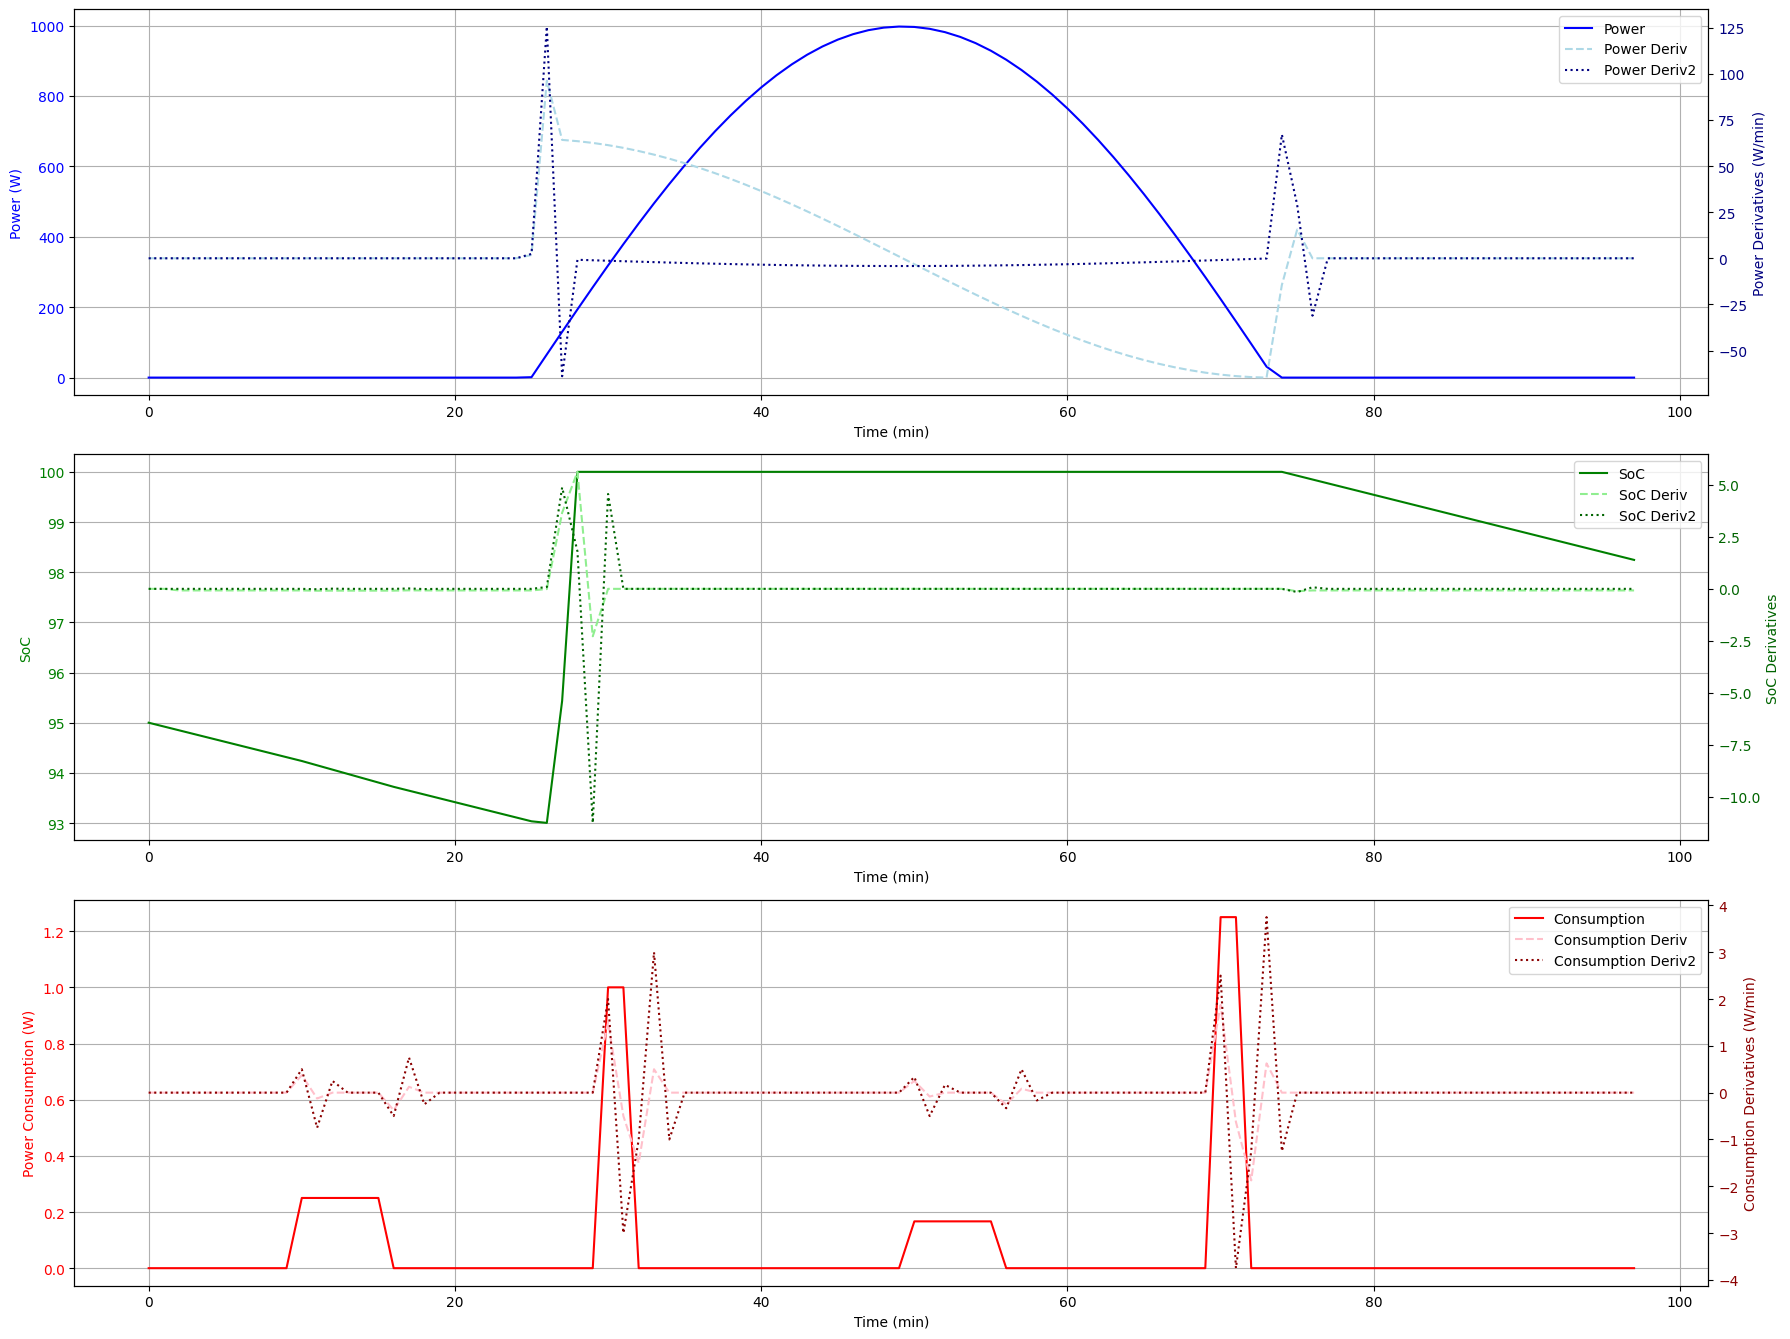

In [80]:
plt.figure(figsize=(18, 13.5))

ax1 = plt.subplot(3, 1, 1)
p1, = ax1.plot(times, powers, label='Power', color='blue')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Power (W)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax1b = ax1.twinx()
p2, = ax1b.plot(times, power_derivs, label='Power Deriv', linestyle='--', color='lightblue')
p3, = ax1b.plot(times, power_derivs2, label='Power Deriv2', linestyle=':', color='navy')
ax1b.set_ylabel('Power Derivatives (W/min)', color='navy')
ax1b.tick_params(axis='y', labelcolor='navy')
ax1.legend(handles=[p1, p2, p3], loc='upper right')

ax2 = plt.subplot(3, 1, 2)
s1, = ax2.plot(times, socs, label='SoC', color='green')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('SoC', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(True)

ax2b = ax2.twinx()
s2, = ax2b.plot(times, soc_derivs, label='SoC Deriv', linestyle='--', color='lightgreen')
s3, = ax2b.plot(times, soc_derivs2, label='SoC Deriv2', linestyle=':', color='darkgreen')
ax2b.set_ylabel('SoC Derivatives', color='darkgreen')
ax2b.tick_params(axis='y', labelcolor='darkgreen')
ax2.legend(handles=[s1, s2, s3], loc='upper right')

ax3 = plt.subplot(3, 1, 3)
c1, = ax3.plot(times, consumption, label='Consumption', color='red')
ax3.set_xlabel('Time (min)')
ax3.set_ylabel('Power Consumption (W)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax3.grid(True)

ax3b = ax3.twinx()
c2, = ax3b.plot(times, consumption_derivs, label='Consumption Deriv', linestyle='--', color='pink')
c3, = ax3b.plot(times, consumption_derivs2, label='Consumption Deriv2', linestyle=':', color='darkred')
ax3b.set_ylabel('Consumption Derivatives (W/min)', color='darkred')
ax3b.tick_params(axis='y', labelcolor='darkred')
ax3.legend(handles=[c1, c2, c3], loc='upper right')

plt.tight_layout()
plt.savefig('final_dynamic_plot.png')
plt.show()

### Parte Final

In [81]:
# Analiza el tiempo que el sistema ha permanecido en diferentes rangos de estado de carga (SoC)
time_in_ranges = analyze_time_in_soc_ranges(socs, Dt)

# Calcula un puntaje de rendimiento basado en el tiempo en cada rango de SoC y normaliza este puntaje
performance_score = 100 * evaluate_performance(time_in_ranges) / (TFinal + 1)

# Imprime el tiempo pasado en cada rango de SoC y el puntaje de rendimiento calculado
print("Time in each SoC range:", time_in_ranges)
print("Performance score:", performance_score)

# Crea un vector con las características de las tareas desde TasksDf, incluyendo potencia, tiempo de inicio,
# duración y prioridades de transmisión y ejecución
tasks_vector = np.hstack((TasksDf['Power'].values, TasksDf['StartTime'].values, TasksDf['Duration'].values, TasksDf['PriorityTransmission'].values, TasksDf['PriorityExecution'].values))

# Combina varios arrays para crear las entradas de una red neuronal, incluyendo potencias, derivadas de potencias,
# estados de carga (SoC) y sus derivadas
neural_network_inputs = np.hstack((powers, power_derivs, power_derivs2, socs, soc_derivs, soc_derivs2), dtype=object)

# Combina las entradas de la red neuronal con las características de las tareas para formar un vector de estado
state_vector = np.hstack((neural_network_inputs, tasks_vector))

# Imprime el vector de estado y los datos generados por cada tarea (en kilobytes)
print("State Vector:", state_vector)
print("Datos generados por cada tarea (KB):", data_generated)

# Imprime el estado histórico de las tareas basado en el tiempo
print_historical_task_status(times, historical_task_status)

# Define un valor de ejemplo para el peso de la bondad del SoC y el número de días desde la regeneración
alpha = 0.5  # Peso de la bondad del SoC
k = 2  # Número de días desde la regeneración

# Calcula una recompensa total basada en múltiples factores, incluyendo las tareas, estado histórico,
# SoC, capacidad máxima de la batería, nivel mínimo seguro de la batería (HardDeck), alpha y sigma
Z = total_reward(TasksDf, historical_task_status, socs, PtBatMax, HardDeck, alpha, sigma, k)

# Imprime la recompensa total calculada
print("Total Reward:", Z)


Time in each SoC range: {'0%-10%': 0, '10%-20%': 0, '20%-30%': 0, '30%-40%': 0, '40%-50%': 0, '50%-60%': 0, '60%-70%': 0, '70%-80%': 0, '80%-90%': 0, '90%-100%': 98.0}
Performance score: 100.0
State Vector: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.1772030326789416 65.72545161471248
 129.9980248114624 193.72534111464537 256.6401060128764 318.47843311774517
 378.9809509950355 437.8938910586581 494.9701519642916 549.9703360382944
 602.6637533947442 652.8293895289906 700.2568323292954 744.7471546183517
 786.1137485229993 824.1831081724935 858.7955574424267 889.8059196918836
 917.0841266847275 940.5157641409825 960.0025516300875 975.4627547931752
 986.8315281653801 994.0611871602499 997.1214080754763 995.999355281039
 990.699735056299 981.2447758502266 967.6741350475629 950.0447326319658
 928.4305124438165 902.9221320340571 873.6265824149152 840.666739302417
 804.1808477329317 764.3219422154457 721.2572048516488 675.167264116099

### Ruta al archivo CSV con las tareas

In [82]:
PATH_TO_CSV = 'tareas.csv'  # Ruta al archivo CSV con las tareas

### Función para cargar tareas desde un archivo CSV


In [83]:
def load_tasks_from_csv(filepath):
    try:
        # Asume que el delimitador es una coma, y especifica los nombres de las columnas si es necesario
        tasks_df = pd.read_csv(filepath, delimiter=',', names=['TaskID', 'Power', 'StartTime', 'Duration', 'PriorityTransmission', 'PriorityExecution'], header=None)
        print("Tareas cargadas correctamente.")
        return tasks_df
    except Exception as e:
        print(f"Error al cargar las tareas: {e}")
        return pd.DataFrame()  # Retorna un DataFrame vacío en caso de error


### Función para simular una orbita
### espera un segundo

In [84]:
# Función para simular una órbita
def simulate_orbit(start_time, tasks_df):
    end_time = start_time + datetime.timedelta(minutes=DURATION_OF_ORBIT)
    current_time = start_time
    while current_time < end_time:
        print(f"Tiempo actual de la simulación: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
        time.sleep(3)  # Simulación en tiempo real, espera un segundo
        current_time += datetime.timedelta(seconds=1)
    return end_time

In [85]:
# Función principal del simulador
def main_simulation_loop():
    current_time = datetime.datetime.now()
    current_orbit = 1
    while True:
        print(f"Iniciando órbita {current_orbit}...")
        tasks_df = load_tasks_from_csv(PATH_TO_CSV)
        if tasks_df.empty:
            print("No hay tareas para ejecutar en esta órbita.")
        else:
            print(tasks_df)
        current_time = simulate_orbit(current_time, tasks_df)
        print(f"Órbita {current_orbit} finalizada. Preparando para la próxima órbita.")
        current_orbit += 1
        time.sleep(5)  # Pausa antes de iniciar la siguiente órbita

In [ ]:
# Ejecutar el simulador
if __name__ == "__main__":
    main_simulation_loop()

Iniciando órbita 1...
Tareas cargadas correctamente.
   TaskID  Power  StartTime  Duration  PriorityTransmission  PriorityExecution
0  TaskID  Power  StartTime  Duration  PriorityTransmission  PriorityExecution
1       1    1.5         10         5                   0.2                0.2
2       2    2.0         30         1                     1                  1
3       3    1.0         50         5                   0.4                0.1
4       4    2.5         70         1                   0.3                0.9
Tiempo actual de la simulación: 2024-05-01 22:42:18
Tiempo actual de la simulación: 2024-05-01 22:42:19
Tiempo actual de la simulación: 2024-05-01 22:42:20
Tiempo actual de la simulación: 2024-05-01 22:42:21
Tiempo actual de la simulación: 2024-05-01 22:42:22
Tiempo actual de la simulación: 2024-05-01 22:42:23
Tiempo actual de la simulación: 2024-05-01 22:42:24
